# Problem 1 (10 pts) Theoretical Task

The pure content-based recommendation models, particularly those built using a single global model of the form $ r \approx \theta x + \epsilon $, provide a very low level of personalization to users.

## Preliminary Statements:

1. **Universality of $ \theta $**: In the single global model, the weight vector $ \theta $ is universal, meaning it's learned across all users and isn't specific to any individual user.
2. **User-Item Interaction**: The relevance score $ r_{ui} $ is a function of the product of the user and item feature vectors. However, since $ \theta $ is universal, this interaction is uniform across all users.
3. **Limitation in Personalization**: Since $ \theta $ doesn't change for different users, the model doesn't account for user-specific biases or preferences that deviate from the average.

## Proof:

Consider two users, $ u_1 $ and $ u_2 $, with their respective feature vectors $ x_{u_1} $ and $ x_{u_2} $. Also, let's consider an item with feature vector $ x_i $.

The relevance scores for the two users for this item are given by:

$$
r_{u_1i} = \theta x_{u_1} + \theta x_i + \epsilon_{u_1i}
$$

$$
r_{u_2i} = \theta x_{u_2} + \theta x_i + \epsilon_{u_2i}
$$

Considering the difference in relevance scores for the two users, we get:

$$
\Delta r_{ui} = r_{u_1i} - r_{u_2i}
$$

$$
\Delta r_{ui} = \theta (x_{u_1} - x_{u_2}) + \epsilon_{\Delta}
$$

Where $ \epsilon_{\Delta} $ represents the difference in errors for the two users.

- If two users have very similar feature vectors $ x $, then their predicted relevance scores for the same item will be very close because they are both scaled by the same universal $ \theta $.
- Even if two users have different feature vectors $ x $, the manner in which these differences are translated into differences in the predicted relevance scores is determined solely by the universal $ \theta $. This means that any idiosyncratic, user-specific preferences or biases that are not captured by their feature vectors will not be reflected in the recommendations, because $ \theta $ is learned globally and is not user-specific.
- Given real-world data, users often share many common attributes (e.g., age groups, geographical locations). In content-based systems, these common attributes often dominate user profiles, especially when explicit preference attributes are sparse. Thus, in such cases, the difference $ x_{u_1i} - x_{u_2i} $ is inherently small for many items.

From the above expression, we observe that the only term introducing a difference in the relevance scores for the two users is the difference in their feature vectors, scaled by the same universal $ \theta $.

Furthermore, for the top-n recommendations, Given:
$$ toprec(u,n) = \arg \max_{i}^{n} r_{ui} $$

This formula states that the top-n recommendations for user $ u $ are the items with the n highest relevance scores $ r_{ui} $.

If the ranking order of $ r_{ui} $ values is similar for many users (due to similar feature values), they'll receive similar top-n items.

Thus, unless the users have distinct feature vectors, their relevance scores for the same item will be almost equivalent, leading to similar recommendations.

For a system to offer true personalization, the weight $ \theta $ should be user-specific, i.e., $ \theta_u $ for each user $ u $. The global model does not allow for this.

## Conclusion:

The single global model $ r \approx \theta x + \epsilon $ offers limited personalization due to the universality of the weight vector $ \theta $. As a result, unless users have vastly different feature vectors, their recommendations will be quite similar, thus validating the claim.


# Problem 2 (20 pts) CONTENT BASED MODELS

In [1]:
import os
import ast
import numpy as np
from numpy.linalg import norm as dense_norm

import pandas as pd
from scipy.sparse import diags
from scipy.sparse.linalg import norm as sparse_norm
from scipy.sparse import issparse

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.preprocessing import StandardScaler



import matplotlib.pyplot as plt
import shap

## Dataset

### Reviews


Lets have a look on our *reviews* dataset. In this dataset we need only four columns with titles *user_id*, *anime_id*, *favorites_anime* and *score*.

- ***user_id*** User profile name. Some profile names are literally insane =)

- ***anime_id*** The mapping of anime titles column onto integers.

- ***score*** grade, how the user with the specific *user_id* evaluated the anime with specific *anime_id*.

-  ***favorites_anime*** List of animes the user with the specific *user_id*  considered as his favourites. **ATTENTION** the animes from this list may not occur in user history (animes user graded). User may have mentioned some animes as favourites, but did not graded them. Automatically, we will consider that the score of favorite animes is **10**



In [2]:
USER_COL = "user_id"
ITEM_COL = "anime_id"
RELEVANCE_COL = "score"

In [3]:
base_path = "./anime_data"

In [4]:
review_data = pd.read_csv(os.path.join(base_path, 'reviews.gz'))

In [5]:
review_data.head()

,uid,user_id,anime_id,text,score,scores,link
0,255938,DesolatePsyche,34096,"First things first. My ""reviews"" system is exp...",8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,Let me start off by saying that Made in Abyss ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,"Art 9/10: It is great, especially the actions ...",7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,Story \r\ntaking place 1 yr from where season ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,Kyoto Animations greatest strength is being ab...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149


#### Do you remember what is the difference between explicit and implicit feedback?

In [6]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print(f'Num reviews = {log.shape[0]},\nnum users = {log[user_id].nunique()},\nnum items = {log[item_id].nunique()}')

In [7]:
get_log_info(review_data, user_id=USER_COL, item_id=ITEM_COL)

Num reviews = 109297,
num users = 37458,
num items = 7636


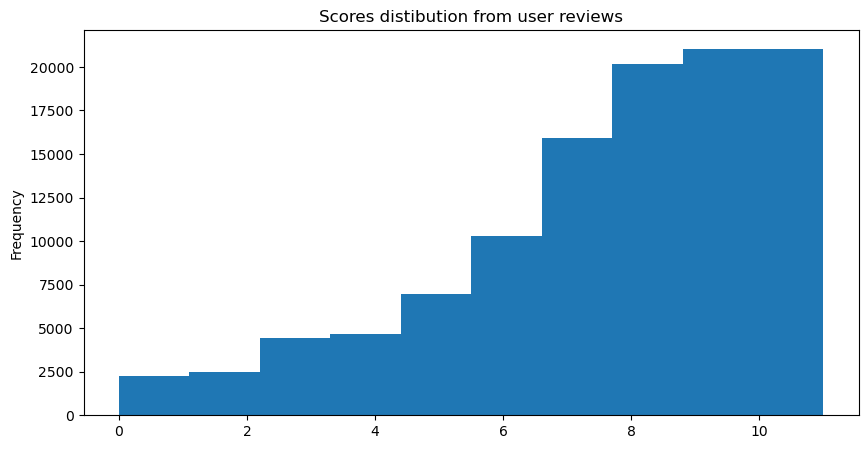

In [8]:
review_data[RELEVANCE_COL].plot.hist(bins=10, figsize=(10, 5), title='Scores distibution from user reviews');

#### How does the distribution of ratings change if we have, for example, a marketplace data?

In [9]:
def group_by_and_plot(df, group_by_name, rating_col_name, quantile=0.99, title=''):
    grouped = df.groupby(group_by_name)[rating_col_name].count()
    print(grouped.describe(percentiles=[0.05, .25, .5, .75, 0.95]))
    grouped[grouped < grouped.quantile(quantile)].plot(kind='hist', bins=20, figsize=(10, 5), title=title)
    return grouped

count    37458.000000
mean         2.917855
std          7.985410
min          1.000000
5%           1.000000
25%          1.000000
50%          1.000000
75%          3.000000
95%          9.000000
max        537.000000
Name: score, dtype: float64


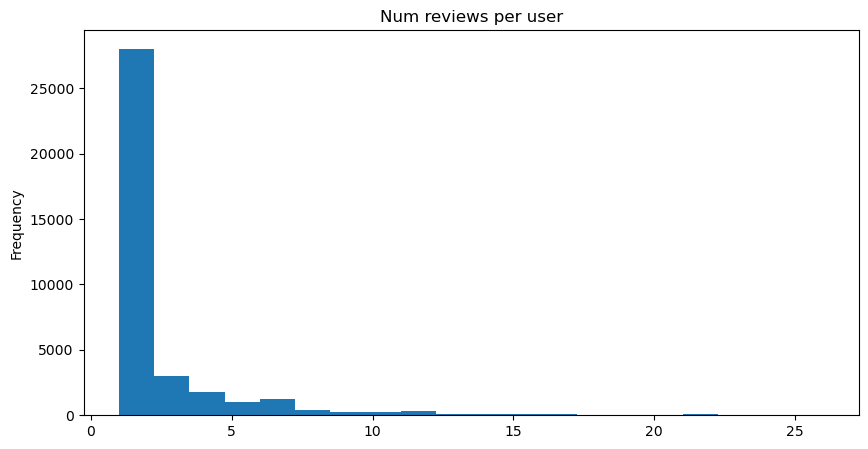

In [10]:
group_by_and_plot(review_data, group_by_name=USER_COL, rating_col_name=RELEVANCE_COL, quantile=0.99, title='Num reviews per user');

count    7636.000000
mean       14.313384
std        39.704994
min         1.000000
5%          1.000000
25%         1.000000
50%         3.000000
75%        11.000000
95%        59.000000
max      1080.000000
Name: score, dtype: float64


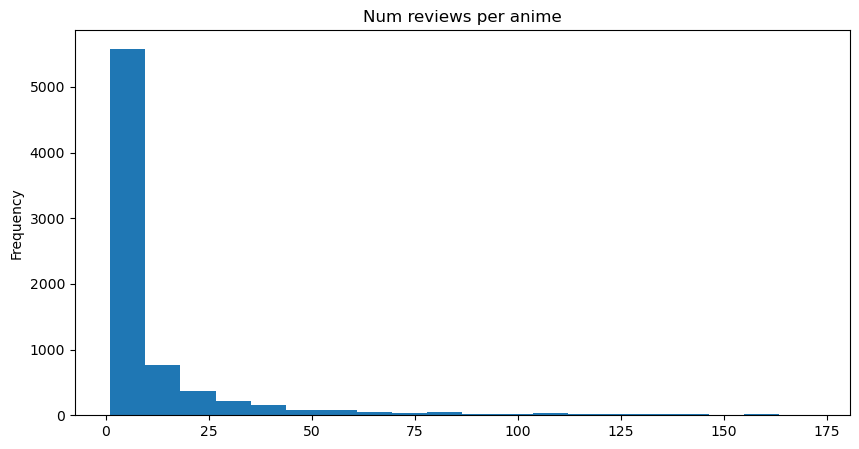

In [11]:
group_by_and_plot(review_data, group_by_name=ITEM_COL, rating_col_name=RELEVANCE_COL, quantile=0.99, title='Num reviews per anime');

#### How many animes could we reliably recommend using popularity-based methods? 

### Animes


The main columns for us are:

- ***anime_id*** - the same id we have in the table above.

- ***synopsis*** - the description of the anime with a specific **anime_id**

- ***score*** - average score over all the grades users or critics  put to the corresponding anime


In [12]:
anime_data = pd.read_csv(os.path.join(base_path, 'animes.gz'), na_filter=False)

In [13]:
anime_data.head(1).T

,0
anime_id,1
title,Cowboy Bebop
synopsis,"In the year 2071, humanity has colonized sever..."
genre,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
aired,"Apr 3, 1998 to Apr 24, 1999"
episodes,26
members,930311
popularity,39
ranked,26.0
score,8.81


In [14]:
anime_data['genre'].str.strip().str.split(", ").explode().value_counts()

Comedy           5640
Action           3572
Fantasy          2971
Adventure        2753
Sci-Fi           2462
Kids             2458
Drama            2457
Shounen          1915
Music            1863
Romance          1762
Slice of Life    1744
School           1567
Supernatural     1358
Hentai           1295
Mecha            1060
Historical       1051
Magic            1013
Seinen            805
Ecchi             740
Sports            679
Mystery           674
Shoujo            668
Parody            619
Super Power       600
Military          541
Space             475
Demons            453
Horror            434
Dementia          402
Harem             374
Martial Arts      367
Game              348
Psychological     322
Police            239
Samurai           199
Vampire           135
Thriller          120
Cars              117
Josei              93
Shounen Ai         91
                   75
Shoujo Ai          73
Yuri               40
Yaoi               40
Name: genre, dtype: int64

In [15]:
anime_data.shape # 7636 in reviews, the rest won't be covered by the popularity-based models

(16216, 12)

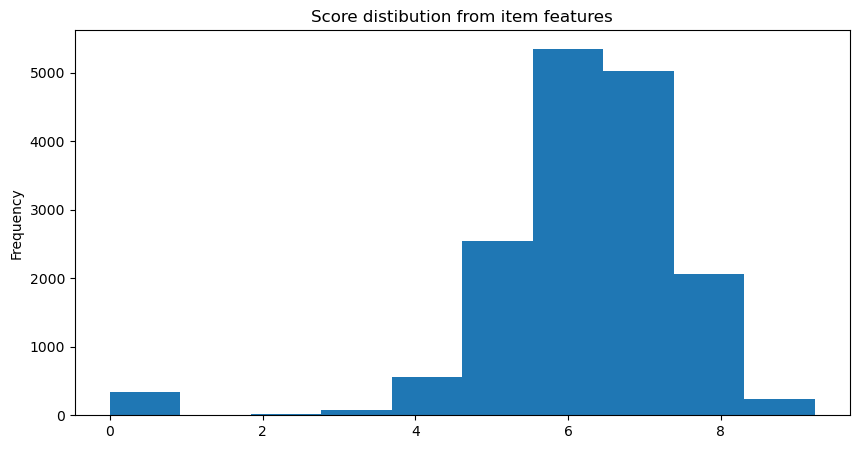

In [16]:
anime_data[RELEVANCE_COL].plot.hist(bins=10, title='Score distibution from item features', figsize=(10, 5));

In [17]:
(anime_data[RELEVANCE_COL] > 0).sum()

15875

In [18]:
all_anime_data = (
    anime_data[['anime_id', 'score']]
    .assign(tokens=anime_data[['title', 'genre', 'synopsis']].apply('; '.join, axis=1))
    .set_index('anime_id')
    # ['tokens']
)

In [19]:
all_anime_data.head()

,score,tokens
anime_id,,
1,8.81,"Cowboy Bebop; Action, Adventure, Comedy, Drama..."
5,8.40,"Cowboy Bebop: Tengoku no Tobira; Action, Drama..."
6,8.28,"Trigun; Action, Sci-Fi, Adventure, Comedy, Dra..."
7,7.32,"Witch Hunter Robin; Action, Magic, Police, Sup..."
8,7.02,"Bouken Ou Beet; Adventure, Fantasy, Shounen, S..."


#### What can we do with these tokens?

### User profiles

This dataset contains additional information about users, including their favorite anime.

- ***user_id*** - the same user id as in the reviews table.

- ***gender*** - user gender

- ***birthday*** - user birthday

- ***favorites_anime*** - a list of user favorites


In [20]:
profile_data = pd.read_csv(os.path.join(base_path, 'profiles.gz'), converters={'favorites_anime': ast.literal_eval})

In [21]:
profile_data.head()

,user_id,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,"Oct 2, 1994","[226, 235, 269, 457, 1482, 1698, 2904, 4981, 5...",https://myanimelist.net/profile/DesolatePsyche
1,baekbeans,Female,"Nov 10, 2000","[853, 918, 3588, 6956, 9253, 11061, 13601, 205...",https://myanimelist.net/profile/baekbeans
2,skrn,NaN,NaN,"[512, 918, 1943, 2904, 9989, 11741, 17074, 232...",https://myanimelist.net/profile/skrn
3,edgewalker00,Male,Sep 5,"[849, 2904, 3588, 5680, 37349]",https://myanimelist.net/profile/edgewalker00
4,aManOfCulture99,Male,"Oct 30, 1999","[235, 849, 2167, 4181, 4382, 5680, 7791, 9617,...",https://myanimelist.net/profile/aManOfCulture99


In [22]:
profile_data.shape

(37458, 5)

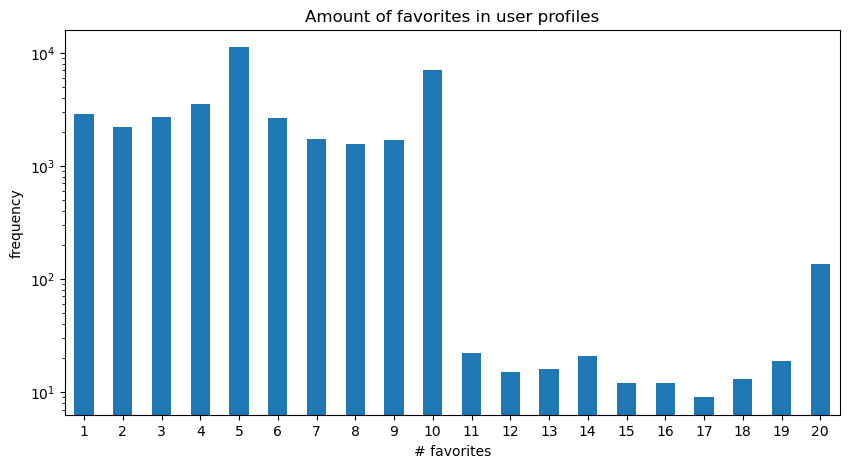

In [23]:
(
    profile_data['favorites_anime']
    .apply(len)
    .value_counts(sort=False).sort_index()#.cumsum()
    .plot.bar(
        logy=True,
        rot=0,
        xlabel='# favorites',
        ylabel='frequency',
        title='Amount of favorites in user profiles',
        figsize=(10, 5)
    )
);

### Favorites ratings

In [24]:
favorites_data = profile_data.set_index('user_id')['favorites_anime']
favorites_scores = pd.merge(
    favorites_data.explode().rename('anime_id').reset_index(),
    review_data[['user_id', 'anime_id', 'score']],
    on = ['user_id', 'anime_id'],
    how = 'left'
)['score']

print(f'Fraction of favorites without the rating: {favorites_scores.isnull().mean():.0%}')

Fraction of favorites without the rating: 93%


- Most of the favorites do not have ratings info.
- For the sake of evaluation in this excercise, we will make two assumptions:
  - favorites are of the highest interest to users,
  - other animes that users rate highly should be somewhat similar to their favorites.

# Data split


- In order to construct test set we use the users who have some anime in their favourites list.
- For these users we take **n_pairs** animes a user liked and **n_pairs** animes the user disliked from their anime reviews.
  - We assume the user liked anime if he put the grade no less than some *score_cutoff* value.
- The quality of predictions is then evaluated by comparing how close the liked animes to the favorites based on the predicted scores.

In [25]:
def get_test_pairs(reviews, favorites, n_pairs, score_cutoff, seed):
    '''
    Construct a dataset consisting of pairs of liked and disliked animes. The likes and dislikes
    are defined by the ratings value: everything below threshold is a dislike, the rest are likes.
        
    The function ensures that the amount of likes and dislikes is the same per each user in data.
    The users that do not contain enough likes or dislikes are discarded from the result.
    The result is to be used for evaluating the quality of recommendations by some algorithms.
    Hence, user favorites are excluded to ensure that there is no trivial solution.
    '''
    rng = np.random.default_rng(seed)
    def strict_sample_no_favs(series):
        # sample `n_pairs` elements from `series`, if not enough data - return empty list,
        # discard favorites, otherwise the evaluation on test pairs against favorites makes no sense
        above_cutoff, user_id = series.name
        allowed_items = np.setdiff1d(series.values, favorites.loc[user_id])
        return rng.choice(allowed_items, n_pairs, replace=False) if len(allowed_items)>=n_pairs else []
    
    test_pairs = (
        reviews
         # split by likes and dislikes, group by users
        .groupby([(reviews["score"] >= score_cutoff), 'user_id'])
        # sample `n_pairs` items (both likes and dislikes), disregard user favorites
        ['anime_id'].apply(strict_sample_no_favs)
         # disregard users that have not enough items
        .loc[lambda x: x.apply(len) > 0]
         # make two columns of likes and dislikes
        .unstack('score')
        # ensure each user has both likes and dislikes
        .dropna()
         # rename by rule `score >= score_cutoff`
        .rename(columns={False: 'dislikes', True: 'likes'})
    )
    return test_pairs

We will generate the training data by excluding animes from the pairs of likes and dislikes contained in the test data. 

In [26]:
def split_anime_train_test_data(reviews, favorites, anime, *, n_pairs=5, score_cutoff=5, seed=0):
    '''
    Function to construct train dataset. It deletes animes that occured in the test set
    to prevent information leakage from test to train.
    '''
    test_data = get_test_pairs(reviews, favorites, n_pairs, score_cutoff, seed)
    test_anime_set = (
        test_data
        .melt(value_name='animes') # reshape 2 columns into signle column
        ['animes'].explode() # flatten all lists into a single long 1d array
        .unique() # get only unique values
    )
    train_data = (
        anime
        # only use known score - to be used as the prediction target,
        # also prevent test data leaks into training
        .query('score > 0 and anime_id not in @test_anime_set')
        # combine several text fields into a unified feature view
        .assign(tokens = lambda x: x[['title', 'genre', 'synopsis']].apply('; '.join, axis=1))
        # only take necessary fields
        .loc[:, ['anime_id', 'tokens', 'score']]
    )
    return train_data, test_data

In [27]:
anime_train, anime_test = split_anime_train_test_data(
    review_data, favorites_data, anime_data, score_cutoff=5
)

In [28]:
anime_train.head()

,anime_id,tokens,score
3,7,"Witch Hunter Robin; Action, Magic, Police, Sup...",7.32
4,8,"Bouken Ou Beet; Adventure, Fantasy, Shounen, S...",7.02
5,15,"Eyeshield 21; Action, Sports, Comedy, Shounen;...",8.02
6,16,"Hachimitsu to Clover; Comedy, Drama, Josei, Ro...",8.11
7,17,"Hungry Heart: Wild Striker; Slice of Life, Com...",7.65


In [29]:
# to evaluate classification/regression metrics

test_animes = (anime_test
        .melt(value_name='animes') # reshape 2 columns into signle column
        ['animes'].explode() # flatten all lists into a single long 1d array
        .unique()) # get only unique values

anime_test_animes = anime_data.query('score > 0 and anime_id in @test_animes') \
        .assign(tokens = lambda x: x[['title', 'genre', 'synopsis']].apply('; '.join, axis=1)) \
        .loc[:, ['anime_id', 'tokens', 'score']]

In [30]:
anime_data.query('score > 0').shape, anime_train.shape[0] + anime_test_animes.shape[0]

((15875, 12), 15875)

In [31]:
anime_test.head()

score,dislikes,likes
user_id,,
-HippySnob-,"[33926, 34712, 35203, 36516, 31804]","[34881, 34662, 32262, 34280, 16918]"
-Remix-,"[25159, 31914, 24655, 31559, 28171]","[15225, 32491, 11889, 20031, 29787]"
0MAN0,"[22199, 13759, 441, 9919, 885]","[35849, 11597, 28223, 33352, 6746]"
2LongDidntReview,"[28619, 28297, 24439, 28927, 18897]","[28121, 28677, 26057, 28497, 27655]"
5camp,"[1530, 8475, 6880, 20785, 101]","[5630, 783, 16201, 202, 10336]"


In [32]:
favorites_data.head()

user_id
DesolatePsyche     [226, 235, 269, 457, 1482, 1698, 2904, 4981, 5...
baekbeans          [853, 918, 3588, 6956, 9253, 11061, 13601, 205...
skrn               [512, 918, 1943, 2904, 9989, 11741, 17074, 232...
edgewalker00                          [849, 2904, 3588, 5680, 37349]
aManOfCulture99    [235, 849, 2167, 4181, 4382, 5680, 7791, 9617,...
Name: favorites_anime, dtype: object

### We build train and test data by randomly choose one liked item from user history.

In [33]:
def construct_test_data(anime_test_df,seed):
    
    np.random.seed(seed)
 
    test_data_liked = anime_test_df['likes'].apply(lambda x: np.random.choice(x, 1)[0])

    test_data = pd.DataFrame({
        'user_id': test_data_liked.index,
        'anime_id': test_data_liked.values
    })
  
    anime_test_df['likes'] = anime_test_df.apply(lambda row: [anime for anime in row['likes'] if anime != test_data_liked[row.name]], axis=1)

    train_data = anime_test_df.copy()
    
    return test_data,train_data

In [34]:
test_data,train_data = construct_test_data(anime_test,seed=56)
test_data,train_data

(              user_id  anime_id
 0         -HippySnob-     16918
 1             -Remix-     15225
 2               0MAN0     28223
 3    2LongDidntReview     28497
 4               5camp     16201
 ..                ...       ...
 291    vigorousjammer       463
 292    wrenflyingaway     31478
 293   xgreeneyednekox      6171
 294           zawa113      1212
 295    zombie_pegasus     21267
 
 [296 rows x 2 columns],
 score                                        dislikes  \
 user_id                                                 
 -HippySnob-       [33926, 34712, 35203, 36516, 31804]   
 -Remix-           [25159, 31914, 24655, 31559, 28171]   
 0MAN0                  [22199, 13759, 441, 9919, 885]   
 2LongDidntReview  [28619, 28297, 24439, 28927, 18897]   
 5camp                  [1530, 8475, 6880, 20785, 101]   
 ...                                               ...   
 vigorousjammer       [14837, 5813, 3816, 12067, 3832]   
 wrenflyingaway       [2251, 31414, 356, 23283, 23289] 

In [35]:
anime_test


score,dislikes,likes
user_id,,
-HippySnob-,"[33926, 34712, 35203, 36516, 31804]","[34881, 34662, 32262, 34280]"
-Remix-,"[25159, 31914, 24655, 31559, 28171]","[32491, 11889, 20031, 29787]"
0MAN0,"[22199, 13759, 441, 9919, 885]","[35849, 11597, 33352, 6746]"
2LongDidntReview,"[28619, 28297, 24439, 28927, 18897]","[28121, 28677, 26057, 27655]"
5camp,"[1530, 8475, 6880, 20785, 101]","[5630, 783, 202, 10336]"
...,...,...
vigorousjammer,"[14837, 5813, 3816, 12067, 3832]","[1130, 6946, 1350, 6616]"
wrenflyingaway,"[2251, 31414, 356, 23283, 23289]","[32093, 30276, 4224, 30015]"
xgreeneyednekox,"[28999, 16067, 34501, 31452, 17513]","[31417, 27441, 15085, 30205]"


# Content-based similarity models

**Model description:**

We build a content-based recommendation model using similarity. The core idea of this model is that if users have liked a certain type of content in the past, they are likely to like similar content in the future. Specifically, we used the descriptive features of anime (i.e., “tokens”) to generate a feature matrix for each anime, and used the user’s preference history (including anime they liked and disliked) to generate a feature matrix for each user. A feature profile.

For feature extraction, we used two methods: simple binary encoding and TF-IDF vectorization. After TF-IDF vectorization, we also normalize the features to ensure that all features are on the same scale.

Recommendations are generated by calculating the similarity between the user vector and the feature matrix of each anime. We also considered anime that users disliked, which were given negative weights in the calculation.

**Why choose this model:**

Dataset: We have a relatively small dataset containing descriptive features and user ratings for each anime. Content-based similarity recommendation is a natural choice because it can directly exploit these descriptive features.

Available features: Our dataset contains descriptive features of anime (i.e. “tokens”) and user ratings. This provides us with enough information to build a content-based similarity model and generate personalized recommendations for users.

Recommendation task: Our goal is to provide each user with anime recommendations that are similar to their historical preferences. Content-based similarity recommendation models can directly use users’ historical preferences and descriptive features of anime to achieve this goal.

In [36]:
sim_config = {
    "vectorizer":{
        "binary": dict( # simple binary token encoder
            min_df = 5,
            max_df = 0.9,
            strip_accents='unicode',
            stop_words = 'english',
            analyzer = 'word',
            binary = True,
        ),
        "tfidf": dict( # TfIDF Vectorizer
            min_df = 5,
            max_df = 0.9,
            strip_accents='unicode',
            stop_words = 'english',
            analyzer = 'word',
            use_idf = True,
            smooth_idf = True,
            sublinear_tf = True,
            binary = False,
            norm="l2",
        ),
    }
}
anime_description = {
    'feedback' : "score",
    "item_features": "tokens",
}

In [41]:
class DenseTransformer(TransformerMixin):
    """
    Convert sparse matrix to dense np array to apply standard scaler with mean.
    """

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()
    
def generate_features(config, trainset, trainset_description, binary_vectorizer):
    """
    Config and fit text vectorizer
    """
    if binary_vectorizer:
        word_vectorizer = CountVectorizer(**config['vectorizer']['binary'])
    else:
        word_vectorizer = Pipeline([("tfidf", TfidfVectorizer(**config['vectorizer']['tfidf'])), 
                                    ('dense', DenseTransformer()), 
                                    ("scaler", StandardScaler())])
    features_column = trainset_description['item_features']
    feature_matrix = word_vectorizer.fit_transform(trainset[features_column])
    return feature_matrix, word_vectorizer

def build_sim_model(config, trainset, trainset_description, binary_vectorizer=True):
    feature_matrix, word_vectorizer = generate_features(config, trainset, trainset_description, binary_vectorizer)
    return feature_matrix, word_vectorizer
    
def generate_feature_profile(items, word_vectorizer, item_features):
    """
    Feature profile of a user
    """
    scores = item_features.loc[items, 'score'].values
    tokens = item_features.loc[items, 'tokens'].values
    feature_matrix = word_vectorizer.transform(tokens)
    weights = scores / np.sum(scores)

    return feature_matrix.T.dot(weights)

def compute_user_similarity(user_id, full_item_feature_matrix, params, dislike_weight):
    
    user_likes = train_data['likes'][user_id]
    user_dislikes = train_data['dislikes'][user_id]

    user_vector_likes = generate_feature_profile(user_likes, params, all_anime_data)
    user_vector_dislikes = generate_feature_profile(user_dislikes, params, all_anime_data)
    
    user_vector = user_vector_likes - dislike_weight * user_vector_dislikes
    
    similarity_scores = full_item_feature_matrix.dot(user_vector)
    
    if issparse(full_item_feature_matrix):
        weights_vector = sparse_norm(full_item_feature_matrix, axis=1)
    else:
        weights_vector = dense_norm(full_item_feature_matrix, axis=1)
        
    if hasattr(weights_vector, "A1"):
        weights_vector = weights_vector.A1
    weights = weights_vector * np.linalg.norm(user_vector)
    epsilon = 1e-10
    normalized_scores = similarity_scores / (weights + epsilon)

    user_likes = set(user_likes)
    user_dislikes = set(user_dislikes)
    
    return normalized_scores, user_likes, user_dislikes


def get_top_n_recommendations(user_id, full_item_feature_matrix, params, dislike_weight, n=10):
    normalized_scores, user_likes, user_dislikes = compute_user_similarity(user_id, full_item_feature_matrix, params, dislike_weight)
    
    all_recommended_indices = np.argsort(-normalized_scores)
    all_recommended_indices = [idx for idx in all_recommended_indices if all_anime_data.index[idx] not in user_likes and all_anime_data.index[idx] not in user_dislikes]
    
    recommended_indices = all_recommended_indices[:n]
    recommendations = all_anime_data.iloc[recommended_indices].index.tolist()

    return recommendations


def hr_at_n(test_item, recommended_items):
    """Calculate HR@n."""
    return int(test_item in recommended_items)

def mrr_at_n(test_item, recommended_items):
    """Calculate MRR@n."""
    if test_item in recommended_items:
        return 1.0 / (recommended_items.index(test_item) + 1)
    else:
        return 0.0
    
def coverage_at_n(recommendations, total_items_count):
    """Calculate Coverage@n."""
    unique_recommended_items = set(item for sublist in recommendations.values() for item in sublist)
    return len(unique_recommended_items) / total_items_count

def evaluate_recommendations(test_liked_anime, recommendations):
    hr_values = []
    mrr_values = []

    for user in anime_test.index:
        test_anime_id = test_liked_anime[test_liked_anime['user_id'] == user]['anime_id'].iloc[0]
        hr_values.append(hr_at_n(test_anime_id, recommendations.get(user, [])))
        mrr_values.append(mrr_at_n(test_anime_id, recommendations.get(user, [])))

    mean_hr = np.mean(hr_values)
    mean_mrr = np.mean(mrr_values)
    total_items_count = len(all_anime_data)
    cov_at_10 = coverage_at_n(recommendations, total_items_count)

    return mean_hr, mean_mrr, cov_at_10



## CountVectorizer Method

In [42]:
%%time
full_item_feature_matrix, sim_params = build_sim_model(sim_config, all_anime_data, anime_description)

CPU times: user 811 ms, sys: 20.2 ms, total: 831 ms
Wall time: 834 ms


### Experiment for dislike_weight

(Uncomment to run)

In [53]:
# dislike_weights = np.linspace(0.1, 1.0, 10)
# results = {}

# for dislike_weight in dislike_weights:
#     sim_rec = {user_id: get_top_n_recommendations(user_id, full_item_feature_matrix, sim_params, dislike_weight=dislike_weight) for user_id in anime_test.index}
    
#     mean_hr, mean_mrr, cov_at_10 = evaluate_recommendations(test_data, sim_rec)
    
#     results[dislike_weight] = {
#         "mean_hr": mean_hr,
#         "mean_mrr": mean_mrr,
#         "cov_at_10": cov_at_10
#     }
# results = pd.DataFrame(results).T
# results

| mean_hr | mean_mrr | cov_at_10 |
|---------|----------|-----------|
|   0.1   | 0.020270 | 0.074926  |
|   0.2   | 0.023649 | 0.079921  |
|   0.3   | 0.027027 | 0.085471  |
|   0.4   | 0.027027 | 0.091638  |
|   0.5   | 0.023649 | 0.098113  |
|   0.6   | 0.023649 | 0.103170  |
|   0.7   | 0.023649 | 0.107610  |
|   0.8   | 0.023649 | 0.111310  |
|   0.9   | 0.023649 | 0.116120  |
|   1.0   | 0.023649 | 0.118155  |


### Best dislike weight =0.2

In [45]:
%%time
sim_rec = {user_id: get_top_n_recommendations(user_id, full_item_feature_matrix, sim_params, dislike_weight=0.4) for user_id in anime_test.index}
    
sim_evaluation = evaluate_recommendations(test_data,sim_rec)

print(f"Similarity Recommendations: HR@10 = {sim_evaluation[0]}, MRR@10 = {sim_evaluation[1]}, Coverage@10 = {sim_evaluation[2]}")

Similarity Recommendations: HR@10 = 0.02702702702702703, MRR@10 = 0.014108751608751607, Coverage@10 = 0.09163788850518007
CPU times: user 29.7 s, sys: 11.7 s, total: 41.4 s
Wall time: 7.02 s


## TF-IDF method

In [46]:
%%time
full_item_feature_matrix_tfidf, sim_params_tfidf = build_sim_model(sim_config, all_anime_data, anime_description, binary_vectorizer=False)


CPU times: user 4.27 s, sys: 2.57 s, total: 6.84 s
Wall time: 7.37 s


In [47]:
%%time
sim_rec_tfidf = {user_id: get_top_n_recommendations(user_id, full_item_feature_matrix_tfidf, sim_params_tfidf, dislike_weight=0.2) for user_id in anime_test.index}

sim_tfidf_evaluation = evaluate_recommendations(test_data,sim_rec_tfidf)

print(f"Similarity Recommendations: HR@10 = {sim_tfidf_evaluation[0]}, MRR@10 = {sim_tfidf_evaluation[1]}, Coverage@10 = {sim_tfidf_evaluation[2]}")

Similarity Recommendations: HR@10 = 0.02027027027027027, MRR@10 = 0.007432432432432433, Coverage@10 = 0.12259496793290577
CPU times: user 7min 19s, sys: 3min 58s, total: 11min 18s
Wall time: 6min 25s


### Since TF-IDf performs not that well, we further use only binary vectorizer for evaluation

## Random Recommandation

In [48]:
def build_random_model(config: dict, trainset: pd.DataFrame):
    n_items = len(trainset)
    random_state = np.random.default_rng(config.get('seed', None))
    return n_items, random_state

def generate_random_scores(params: tuple, n_users: int):
    n_items, random_state = params
    scores = random_state.random((n_users, n_items))
    return scores

def generate_random_recommendations(scores: np.ndarray, topn: int=10):
    recommendations = np.apply_along_axis(topidx, 1, scores, topn)
    return recommendations

def topidx(a: np.ndarray, topn: int):
    parted = np.argpartition(a, -topn)[-topn:]
    return parted[np.argsort(-a[parted])]

In [49]:
%%time
test_users = anime_test.index.tolist()
rnd_params = build_random_model({'seed': 42}, all_anime_data)
rnd_scores = generate_random_scores(rnd_params, len(test_users))
rnd_recommendations_matrix = generate_random_recommendations(rnd_scores, topn=10)
random_rec = {user_id: rnd_recommendations_matrix[i].tolist() for i, user_id in enumerate(test_users)}

random_evaluation = evaluate_recommendations(test_data, random_rec)
print(f"Random Recommendations: HR@10 = {random_evaluation[0]}, MRR@10 = {random_evaluation[1]}, Coverage@10 = {random_evaluation[2]}")

Random Recommendations: HR@10 = 0.0033783783783783786, MRR@10 = 0.0016891891891891893, Coverage@10 = 0.16637888505180068
CPU times: user 168 ms, sys: 14.3 ms, total: 182 ms
Wall time: 185 ms


## Popularity Recommandation

In [50]:
def build_popularity_model(train_data):
    all_liked_animes = np.concatenate([train_data['likes'].explode().values])
    unique, counts = np.unique(all_liked_animes, return_counts=True)
    item_popularity = dict(zip(unique, counts))
    return item_popularity

def generate_popularity_scores(item_popularity, all_data):
    max_popularity = max(item_popularity.values())
    popularity_scores = np.array([item_popularity.get(index, 0) / max_popularity for index in all_data.index])
    return popularity_scores

def downvote_seen_items(scores, train_data, test_users):
    for user in test_users:
        seen_items = np.concatenate([train_data.loc[user, 'likes'], train_data.loc[user, 'dislikes']])
        idxs = np.where(np.isin(all_anime_data.index.values, seen_items))[0]
        scores[idxs] = -1
    return scores

def generate_popularity_recommendations(popularity_scores, test_users, n=10):
    recommendations = {}
    for user in test_users:
        user_scores = popularity_scores.copy()
        user_scores = downvote_seen_items(user_scores, train_data, [user])
        top_n_items = user_scores.argsort()[-n:][::-1]
        recommendations[user] = all_anime_data.index[top_n_items].tolist()
    return recommendations

In [51]:
%%time
test_users = anime_test.index.tolist()
item_popularity = build_popularity_model(train_data)
popularity_scores = generate_popularity_scores(item_popularity, all_anime_data)
popularity_rec = generate_popularity_recommendations(popularity_scores, test_users)

popularity_evaluation = evaluate_recommendations(test_data, popularity_rec)
print(f"Popularity Recommendations: HR@10 = {popularity_evaluation[0]}, MRR@10 = {popularity_evaluation[1]}, Coverage@10 = {popularity_evaluation[2]}")


Popularity Recommendations: HR@10 = 0.010135135135135136, MRR@10 = 0.0011958386958386958, Coverage@10 = 0.001356684755796744
CPU times: user 284 ms, sys: 8.52 ms, total: 292 ms
Wall time: 307 ms


## Results

### Pair = 5

In [52]:
evaluation_data = {
    'HR': [sim_evaluation[0], random_evaluation[0], popularity_evaluation[0]],
    'MRR': [sim_evaluation[1], random_evaluation[1], popularity_evaluation[1]],
    'Coverage': [sim_evaluation[2], random_evaluation[2], popularity_evaluation[2]]
}

evaluation_df = pd.DataFrame(evaluation_data, index=['Similarity', 'Random', 'Popularity'])

evaluation_df

,HR,MRR,Coverage
Similarity,0.027027,0.014109,0.091638
Random,0.003378,0.001689,0.166379
Popularity,0.010135,0.001196,0.001357


### Futhermore, for other pairs we have:


**Pair = 3**  dislike Weight = 0.1

|            | HR        | MRR      | Coverage |
|------------|-----------|----------|----------|
| Similarity | 0.027299  | 0.008113 | 0.158855 |
| Random     | 0.000000  | 0.000000 | 0.346880 |
| Popularity | 0.040230  | 0.012649 | 0.000925 |
		


**Pair = 4**  dislike Weight = 0.2

|            | HR        | MRR      | Coverage |
|------------|-----------|----------|----------|
| Similarity | 0.020642  | 0.008658 | 0.113407 |
| Random     | 0.000000  | 0.000000 | 0.234891 |
| Popularity | 0.036697  | 0.010821 | 0.000987 |

		




### Model adjustment and evaluation

#### 1. Adjust `dislike_weight`

We adjusted `dislike_weight` to find the best weight value for different user training data sets (different `pair` values).

#### 2. Adjust `pair`

We also adjusted the user dataset size (via the `pair` value) to evaluate how more or less user preference data affects the quality of recommendations.

### Result analysis

1. **Adjust `dislike_weight`**:
     * As `Pair` increases, the dislike_weight of the model decreases slightly for Pair=3 and Pair=4, but for Pair=5, the dislike_weight of the model improves.
     * This shows that different weighting strategies are needed for user data sets of different sizes.

2. **Adjust `pair`**:
     * When increasing from Pair=3 to Pair=4, the performance of the similarity-based model decreases slightly, but improves again when Pair=5.

3. **Comparison with baseline model**:
     * The performance of the random recommendation model is low in all cases, while the performance of the popularity model decreases as the Pair value increases.
     * Our similarity-based model outperforms or is close to the popularity model in most cases.
     * Similarity-based models outperform random recommendations in most cases, which proves the effectiveness of content-based recommendation methods.

     * Popularity-based models perform well on HR and MRR, but have very low coverage. This means it tends to recommend only those anime that are the most popular, while ignoring other content that might appeal to some users.